Epoch   500 | PDE loss: 1.336e-04 | Data loss: 2.930e-04 | IC loss: 2.690e-05 | Total: 4.534e-04
Epoch  1000 | PDE loss: 7.008e-05 | Data loss: 3.063e-04 | IC loss: 2.620e-05 | Total: 4.025e-04
Epoch  1500 | PDE loss: 3.917e-05 | Data loss: 3.173e-04 | IC loss: 2.575e-05 | Total: 3.822e-04
Epoch  2000 | PDE loss: 2.787e-05 | Data loss: 3.237e-04 | IC loss: 2.549e-05 | Total: 3.771e-04
Epoch  2500 | PDE loss: 2.450e-05 | Data loss: 3.264e-04 | IC loss: 2.537e-05 | Total: 3.762e-04
Epoch  3000 | PDE loss: 2.374e-05 | Data loss: 3.269e-04 | IC loss: 2.532e-05 | Total: 3.760e-04
Epoch  3500 | PDE loss: 2.369e-05 | Data loss: 3.267e-04 | IC loss: 2.529e-05 | Total: 3.757e-04
Epoch  4000 | PDE loss: 2.380e-05 | Data loss: 3.264e-04 | IC loss: 2.526e-05 | Total: 3.754e-04
Epoch  4500 | PDE loss: 2.403e-05 | Data loss: 3.258e-04 | IC loss: 2.528e-05 | Total: 3.751e-04
Epoch  5000 | PDE loss: 2.430e-05 | Data loss: 3.254e-04 | IC loss: 2.520e-05 | Total: 3.749e-04


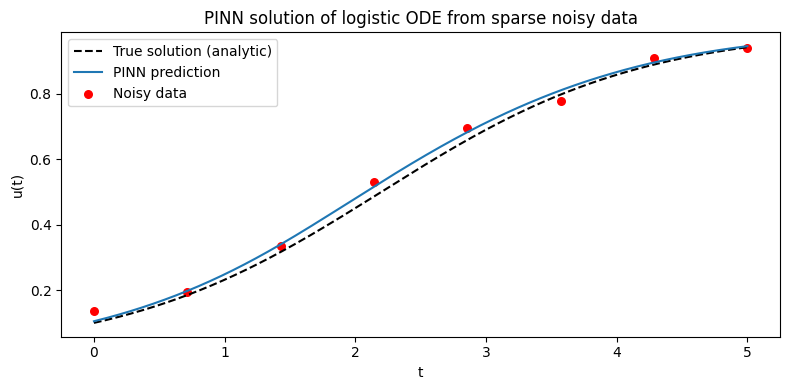

In [39]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

#Problem: logistic ODE

r = 1.0
K = 1.0
u0 = 0.1
T_final = 5.0


def analytic_solution(t):
    t = np.array(t, dtype=np.float64)
    return K / (1.0 + ((K - u0) / u0) * np.exp(-r * t))


#observation points

np.random.seed(0)
torch.manual_seed(0)

# A few observation times (sparse data)
t_obs_np = np.linspace(0.0, T_final, 8)  # only 8 data points
u_true_np = analytic_solution(t_obs_np)
noise_std = 0.02
u_obs_np = u_true_np + noise_std * np.random.randn(*u_true_np.shape)

# Convert to tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
t_obs = torch.tensor(t_obs_np, dtype=torch.float32, device=device).unsqueeze(1)  # (N_obs, 1)
u_obs = torch.tensor(u_obs_np, dtype=torch.float32, device=device).unsqueeze(1)  # (N_obs, 1)

# Collocation points for ODE residual (denser)
N_col = 100
t_col = torch.linspace(0.0, T_final, N_col, device=device).unsqueeze(1)  # (N_col, 1)


#model

class PINN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        net = []
        for i in range(len(layers) - 1):
            net.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers) - 2:
                net.append(nn.Tanh())
        self.net = nn.Sequential(*net)

    def forward(self, t):
        return self.net(t)



model = PINN([1, 32, 32, 1]).to(device)


#losses

def pinn_residual_loss(model, t_in):
    t_in = t_in.clone().detach().requires_grad_(True)
    u_pred = model(t_in)
    du_dt = torch.autograd.grad(
        u_pred,
        t_in,
        grad_outputs=torch.ones_like(u_pred),
        create_graph=True
    )[0]
    rhs = r * u_pred * (1.0 - u_pred / K)
    residual = du_dt - rhs
    return torch.mean(residual**2)


def data_loss(model, t_data, u_data):
    u_pred = model(t_data)
    return torch.mean((u_pred - u_data)**2)


def ic_loss(model):
    t0 = torch.zeros((1, 1), dtype=torch.float32, device=device)
    u0_pred = model(t0)
    return torch.mean((u0_pred - u0)**2)


#train

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

lambda_pde = 1.0
lambda_data = 1.0
lambda_ic = 1.0

n_epochs = 5000
print_every = 500

for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad()

    loss_pde = pinn_residual_loss(model, t_col)
    loss_data = data_loss(model, t_obs, u_obs)
    loss_ic = ic_loss(model)

    loss = lambda_pde * loss_pde + lambda_data * loss_data + lambda_ic * loss_ic
    loss.backward()
    optimizer.step()

    if epoch % print_every == 0:
        print(f"Epoch {epoch:5d} | "
              f"PDE loss: {loss_pde.item():.3e} | "
              f"Data loss: {loss_data.item():.3e} | "
              f"IC loss: {loss_ic.item():.3e} | "
              f"Total: {loss.item():.3e}")


#eval, plot

model.eval()
with torch.no_grad():
    t_plot = torch.linspace(0.0, T_final, 400, device=device).unsqueeze(1)
    u_pinn = model(t_plot).cpu().numpy().flatten()

t_plot_np = t_plot.cpu().numpy().flatten()
u_true_dense = analytic_solution(t_plot_np)

plt.figure(figsize=(8, 4))

# True analytic solution
plt.plot(t_plot_np, u_true_dense, "k--", label="True solution (analytic)")

# PINN prediction
plt.plot(t_plot_np, u_pinn, label="PINN prediction")

# Noisy observations
plt.scatter(t_obs_np, u_obs_np, color="red", s=30, label="Noisy data")

plt.xlabel("t")
plt.ylabel("u(t)")
plt.title("PINN solution of logistic ODE from sparse noisy data")
plt.legend()
plt.tight_layout()
plt.show()


Device: cpu
checkpoint directory created: ./model
saving model version 0.0
Epoch   500 | Res loss = 2.834e+01 | Data loss = 1.880e-01 | Total = 2.853e+01
Epoch  1000 | Res loss = 2.062e+01 | Data loss = 7.947e-02 | Total = 2.070e+01
Epoch  1500 | Res loss = 1.336e+01 | Data loss = 2.222e-02 | Total = 1.338e+01
Epoch  2000 | Res loss = 7.154e+00 | Data loss = 3.694e-03 | Total = 7.157e+00
Epoch  2500 | Res loss = 3.534e+00 | Data loss = 9.925e-04 | Total = 3.535e+00
Epoch  3000 | Res loss = 1.745e+00 | Data loss = 4.933e-04 | Total = 1.745e+00
Epoch  3500 | Res loss = 3.657e+00 | Data loss = 3.578e-04 | Total = 3.657e+00
Epoch  4000 | Res loss = 3.669e-01 | Data loss = 6.312e-04 | Total = 3.675e-01


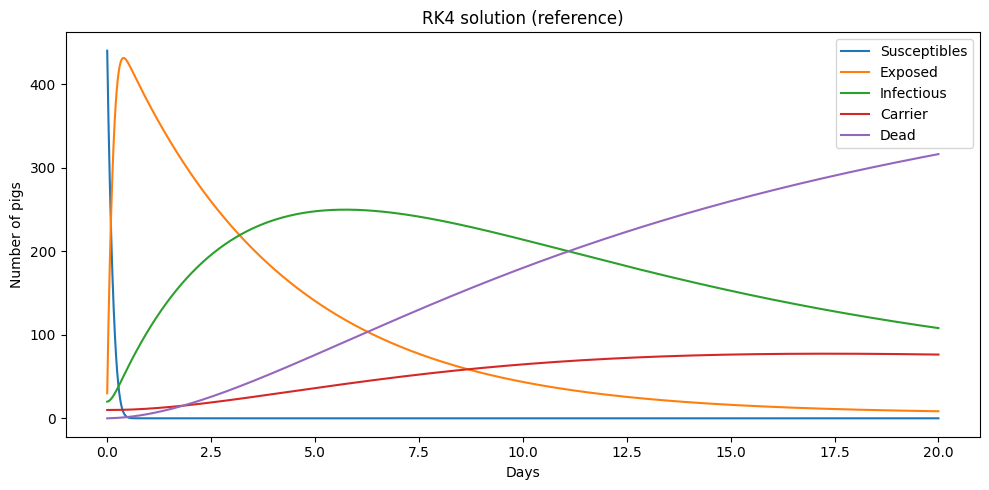

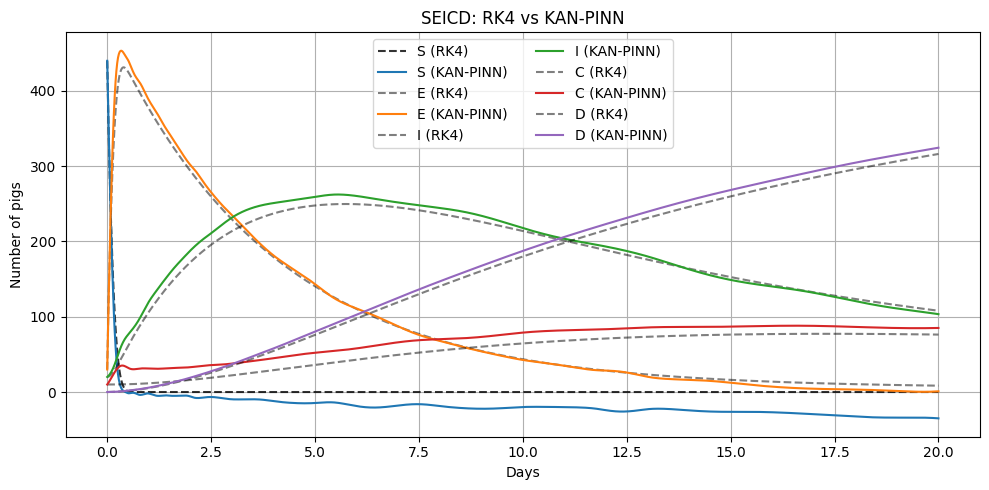

In [ ]:
from kan import *
import matplotlib.pyplot as plt
from torch import autograd
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn


#PARAMETERS

# for RK4 reference
t_0 = 0.0
t_f = 20.0
N   = 2**16  

#global parameters
Y_0 = [440, 30, 20, 10, 0]

mu    = 0.0027
beta  = 0.3
gamma = 0.125
p     = 0.7
sigma = 0.25
kappa = 0.06
eps   = 0.3

#sampled data points 
n_data = 64


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

#RK4

def RK4sys(f, y_0, t_0, t_f, N):
    h = (t_f - t_0) / N
    t = np.linspace(t_0, t_f, N + 1)
    f_ = lambda t, y: np.asarray(f(t, y))
    y = np.zeros((N + 1, len(y_0)))
    y[0] = y_0

    for n in range(0, N):
        k1 = f_(t[n], y[n])
        k2 = f_(t[n] + 0.5 * h, y[n] + h * 0.5 * k1)
        k3 = f_(t[n] + 0.5 * h, y[n] + h * 0.5 * k2)
        k4 = f_(t[n] + h,       y[n] + h * k3)
        y[n+1] = y[n] + h * ((1.0 / 6.0) * k1 +
                             (1.0 / 3.0) * k2 +
                             (1.0 / 3.0) * k3 +
                             (1.0 / 6.0) * k4)

    return h, y, t


# scalar ODE
def f(t, y):
    y1, y2, y3, y4, y5 = y
    s = y1 + y2 + y3 + y4 + y5
    return [
        -beta * y1 * (y3 + eps * y4) + mu * s - mu * y1,
        beta * y1 * (y3 + eps * y4) - (sigma + mu) * y2,
        sigma * y2 + kappa * y4 - gamma * p * y3 - gamma * (1 - p) * y3 - mu * y3,
        gamma * (1 - p) * y3 - (kappa + mu) * y4,
        gamma * p * y3
    ]

# torch compatible ODE
def f_torch_batched(y):
    S = y[:, 0:1]
    E = y[:, 1:2]
    I = y[:, 2:3]
    C = y[:, 3:4]
    D = y[:, 4:5]

    total = S + E + I + C + D

    dS = -beta * S * (I + eps * C) + mu * total - mu * S
    dE =  beta * S * (I + eps * C) - (sigma + mu) * E
    dI =  sigma * E + kappa * C - gamma * p * I - gamma * (1 - p) * I - mu * I
    dC =  gamma * (1 - p) * I - (kappa + mu) * C
    dD =  gamma * p * I

    return torch.cat([dS, dE, dI, dC, dD], dim=1)


#rk4 reference solution
h, y_ref, t_ref = RK4sys(f, Y_0, t_0, t_f, N)

# unpack for plotting
S_ref = y_ref[:, 0]
E_ref = y_ref[:, 1]
I_ref = y_ref[:, 2]
C_ref = y_ref[:, 3]
D_ref = y_ref[:, 4]


###Generate data points from known solution
Y0_np = np.array(Y_0, dtype=np.float32)
N_pop = float(Y0_np.sum())#entire population (for scaling)

#sample points, their time and respective true Y value
idx_data = np.linspace(0, len(t_ref) - 1, n_data, dtype=int)
t_data_np = t_ref[idx_data]
Y_data_np = y_ref[idx_data, :].astype(np.float32)

# scale time and Y values
def scale_t(t):
    return t / t_f

def unscale_t(tau):
    return tau * t_f

Y0_scaled = torch.tensor(Y0_np / N_pop, dtype=torch.float32, device=device).unsqueeze(0)
t_data = torch.tensor(scale_t(t_data_np), dtype=torch.float32, device=device).unsqueeze(1)
Y_data_scaled = torch.tensor(Y_data_np / N_pop, dtype=torch.float32, device=device)

# collocation points in scaled time, here tau is between 0 and 1
N_col = 200
tau_col = torch.linspace(0.0, 1.0, N_col, device=device).unsqueeze(1)


#PINN implementation. Initial conditions are hard set

#Base KAN
base_kan = KAN(width=[1, 8, 5], grid=5, k=3, seed=0)
base_kan = base_kan.to(device)
base_kan.speed()#Otherwise running time is around 10 minutes

#This wrapper enforces the goven initial conditions. While the IC-s are learnable, and there are multiple examples of this, 
# in this case learned IC-s lead to significantly worse model. Might be a mistake on my part
class ICWrapper(nn.Module):
    def __init__(self, base_model, Y0_scaled):
        super().__init__()
        self.base_model = base_model
        self.register_buffer("Y0_scaled", Y0_scaled.clone())

    def forward(self, tau):
        g = self.base_model(tau)
        return self.Y0_scaled + tau * g

model = ICWrapper(base_kan, Y0_scaled).to(device)

#Define different loss functions

def pinn_residual_loss(model, tau_in):
    
    tau = tau_in.clone().detach().requires_grad_(True)
    y_scaled = model(tau)

    # dy_scaled / d tau
    dy_scaled_dtau = torch.zeros_like(y_scaled)
    for k in range(5):
        grad_k = autograd.grad(y_scaled[:, k].sum(), tau, create_graph=True)[0]
        dy_scaled_dtau[:, k:k+1] = grad_k

    # back to physical units
    y_unscaled = N_pop * y_scaled

    # safety measure, as NANs appeared during training at some points
    y_unscaled_clamped = torch.clamp(y_unscaled, min=0.0, max=5.0 * N_pop)

    rhs_unscaled = f_torch_batched(y_unscaled_clamped)  # dy/dt

    # transform to scaled variables / scaled time
    rhs_scaled_dtau = (t_f / N_pop) * rhs_unscaled

    residuals = dy_scaled_dtau - rhs_scaled_dtau
    return torch.mean(residuals**2)

#this is the loss relative to given data points
def data_loss(model, t_data_scaled, Y_data_scaled):
    y_pred_scaled = model(t_data_scaled)
    return torch.mean((y_pred_scaled - Y_data_scaled)**2)


lambda_res  = 1.0
lambda_data = 1.0

def total_loss(model):
    L_res  = pinn_residual_loss(model, tau_col)
    L_data = data_loss(model, t_data, Y_data_scaled)
    L      = lambda_res * L_res + lambda_data * L_data
    return L, L_res, L_data

#Training loop with Adam

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
max_grad_norm = 1.0
epochs = 4000
log_every = 500

for ep in range(1, epochs + 1):
    optimizer.zero_grad()
    L, L_res, L_data = total_loss(model)

    if not torch.isfinite(L):
        print(f"Non-finite loss at epoch {ep}: L={L}, L_res={L_res}, L_data={L_data}")
        break

    L.backward()
    #Safety measure
    nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
    optimizer.step()

    if ep % log_every == 0:
        print(f"Epoch {ep:5d} | Res loss = {L_res.item():.3e} | Data loss = {L_data.item():.3e} | Total = {L.item():.3e}")

#Evaluation, scaling back, plotting

#model.eval()
with torch.no_grad():
    tau_plot = torch.linspace(0.0, 1.0, 1000, device=device).unsqueeze(1)
    y_scaled_pred = model(tau_plot).cpu().numpy()
    y_pred = N_pop * y_scaled_pred
    t_plot = unscale_t(tau_plot.cpu().numpy().flatten())

S_pinn = y_pred[:, 0]
E_pinn = y_pred[:, 1]
I_pinn = y_pred[:, 2]
C_pinn = y_pred[:, 3]
D_pinn = y_pred[:, 4]

#RK4 plot

plt.figure(figsize=(10,5))
plt.plot(t_ref, S_ref,
         t_ref, E_ref,
         t_ref, I_ref,
         t_ref, C_ref,
         t_ref, D_ref)
plt.legend(['Susceptibles', 'Exposed', 'Infectious', 'Carrier', 'Dead'])
plt.ylabel("Number of pigs")
plt.xlabel("Days")
plt.title("RK4 solution (reference)")
plt.tight_layout()

#KAN plot

plt.figure(figsize=(10,5))
plt.plot(t_ref, S_ref, 'k--', alpha=0.8, label='S (RK4)')
plt.plot(t_plot, S_pinn, label='S (KAN-PINN)')

plt.plot(t_ref, E_ref, 'k--', alpha=0.5, label='E (RK4)')
plt.plot(t_plot, E_pinn, label='E (KAN-PINN)')

plt.plot(t_ref, I_ref, 'k--', alpha=0.5, label='I (RK4)')
plt.plot(t_plot, I_pinn, label='I (KAN-PINN)')

plt.plot(t_ref, C_ref, 'k--', alpha=0.5, label='C (RK4)')
plt.plot(t_plot, C_pinn, label='C (KAN-PINN)')

plt.plot(t_ref, D_ref, 'k--', alpha=0.5, label='D (RK4)')
plt.plot(t_plot, D_pinn, label='D (KAN-PINN)')

plt.xlabel("Days")
plt.ylabel("Number of pigs")
plt.title("SEICD: RK4 vs KAN-PINN")
plt.legend(ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()


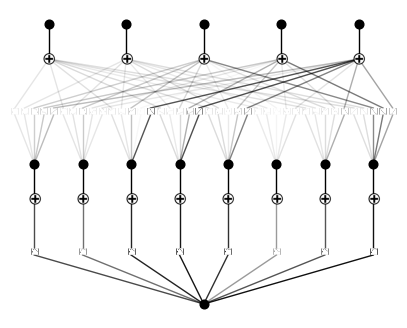

In [ ]:

base_kan.save_act = True
ttt = torch.linspace(0, 1, 200, device=device).unsqueeze(1)
base_kan(ttt)
base_kan.plot()


